In [2]:
!pip install ipywidgets --upgrade

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
import os

In [4]:
import torch

/shared/home/u076079/envs/LSTM_torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
torch.__version__

'1.13.1+cu116'

In [6]:
import torchtext

In [7]:
torchtext.__version__

'0.14.1'

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [72]:
#device = 'cpu'

In [9]:
device

'cuda'

In [10]:
from torchtext.datasets import SQuAD1

In [11]:
train, test = SQuAD1("root")

In [12]:
from modules.data import get_dataframe,  get_pairs_from_df, cols, sample_df_perc, get_thresholds, get_outliers, tokenize_sentence, remove_least_common, to_tensor,  filter_sentences

[nltk_data] Downloading package wordnet to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# get train and test dataframes of sentences
train_df, test_df = get_dataframe(train), get_dataframe(test)

In [14]:
train_df = sample_df_perc(train_df, 0.2)

In [15]:
test_df = sample_df_perc(test_df, 0.2)

In [16]:
train_df.shape, test_df.shape

((17519, 2), (2114, 2))

In [17]:
train_df.head()

,Question,Answer
0,What language family is Somali a part of?,Afro-Asiatic
1,For what was most of the the Bitumont plant's ...,roofs
2,When did the financial institution crisis hit ...,September and October 2008
3,Which cost less in stores: PS3 or Wii?,Wii
4,What is the alternate name of Chuck Ford Park?,Lakeside Park


In [18]:
import random

rand_question = train_df.at[random.randint(0,train_df.shape[0]), 'Question']
print(rand_question)

print(tokenize_sentence(rand_question))
print(tokenize_sentence(rand_question, normalization='stem'))

What region of the Philippines has a large Muslim population?
['what', 'region', 'philippines', 'large', 'muslim', 'population']
['what', 'region', 'philippin', 'larg', 'muslim', 'popul']


# Vocabulary

In [19]:
from modules.vocab import Vocab

## Make pairs to add to the vocabularies. 

#### Only the questions will be normalized (stemmed) but not the answers - otherwise we would get stemmed words in the chatbot answers

In [20]:
for col, norm in zip(cols, ['stem', None]):
    train_df[f'{col}_tokens'] = train_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [21]:
for col, norm in zip(cols, ['stem', None]):
    test_df[f'{col}_tokens'] = test_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [22]:
train_df.sample(3)

,Question,Answer,Question_tokens,Answer_tokens
13865,What was the new Ottoman court system known as?,Nizamiye,"[what, new, ottoman, court, system, known]",[nizamiye]
10359,When in his life did Spielberg 'feel like an a...,during childhood,"[when, life, spielberg, feel, like, alien]",[childhood]
11295,Which theory proposes that adults and adolesce...,behavioral decision-making theory,"[which, theori, propos, adult, adolesc, weigh,...","[behavioral, decisionmaking, theory]"


In [23]:
test_df.sample(3)

,Question,Answer,Question_tokens,Answer_tokens
1912,In what year was same-sex marriage legalized n...,2016,"[what, year, samesex, marriag, legal, nationwid]",[2016]
1542,How old was Peyton Manning when he played in S...,39,"[how, old, peyton, man, when, play, super, bow...",[39]
1469,What was the name for the new radio concept de...,LOVE Radio,"[what, name, new, radio, concept, design, alle...","[love, radio]"


In [24]:
cols_tokens = [f'{col}_tokens' for col in cols]

In [25]:
train_pairs = get_pairs_from_df(train_df, cols_tokens)

In [26]:
test_pairs = get_pairs_from_df(test_df, cols_tokens)

In [27]:
Q_vocab, A_vocab = Vocab(), Vocab()

In [28]:
for pair in train_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [29]:
Q_vocab.n_words, A_vocab.n_words, 

(13051, 15991)

In [30]:
for pair in test_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [31]:
Q_vocab.n_words, A_vocab.n_words 

(13964, 17179)

## Functions for some data analysis

In [32]:
from modules.stats import sentences_stats, histograms

In [33]:
# statistics for tokenized sentences
sentences_stats(train_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.42
	         median: 6.00
	         minimum: 1
	         maximum: 20)
Sentences in column Answer_tokens:
	         mean: 2.45
	         median: 2.00
	         minimum: 0
	         maximum: 22)


In [34]:
# statistics for tokenized sentences
sentences_stats(test_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.47
	         median: 6.00
	         minimum: 2
	         maximum: 17)
Sentences in column Answer_tokens:
	         mean: 2.32
	         median: 2.00
	         minimum: 0
	         maximum: 14)


## Remove the least common words from the sentences

In [35]:
# how many times at most a word occurs to be considered an outlier
outlier_threshold = 1

In [36]:
get_outliers(Q_vocab, outlier_threshold+1), get_outliers(A_vocab, outlier_threshold+1)

(['bitumont',
  'waterproof',
  'chuck',
  'pup',
  'finder',
  'interrog',
  'geeche',
  'plini',
  'puppi',
  'slice',
  '1624',
  'architechtur',
  'philippi',
  'toofast',
  'declassif',
  'passov',
  'shavuot',
  'biologist',
  'eugen',
  'blackbird',
  'aboard',
  'fg',
  'panorama',
  'soka',
  'gakkai',
  'dowtown',
  'leisur',
  'pork',
  'pickl',
  'crisp',
  'overhelm',
  'heidegg',
  'mildr',
  'kemper',
  'isoiec',
  '138183',
  'hardcor',
  'techno',
  'nun',
  'dualshock',
  'okinawa',
  'solidar',
  'wang',
  'mang',
  'undocu',
  'shore',
  'jaun',
  'bermudez',
  'hockfield',
  'armagm',
  'merton',
  'bloem',
  'bouquet',
  'upanishad',
  'antitax',
  'geodes',
  'ibrahim',
  'i2a1b1',
  'cenozo',
  'thiazid',
  'antihypertens',
  'cooker',
  'motet',
  'wider',
  'sputnik',
  'inviron',
  'serotonin',
  'limbic',
  'jacki',
  'vicin',
  'bosniaherzegovina',
  'cleanup',
  'shramana',
  'berti',
  'tidewat',
  'conglomer',
  'preliminari',
  'conservat',
  'interc',


In [37]:
q_outliers, a_outliers = get_outliers(Q_vocab,outlier_threshold+1), get_outliers(A_vocab,outlier_threshold+1)

In [38]:
train_df_final = remove_least_common(train_df, cols_tokens, [q_outliers, a_outliers])

In [39]:
test_df_final = remove_least_common(test_df, cols_tokens, [q_outliers, a_outliers])

In [40]:
# tokenized & least common removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.04
	         median: 6.00
	         minimum: 0
	         maximum: 18)
Sentences in column Answer_tokens:
	         mean: 1.90
	         median: 1.00
	         minimum: 0
	         maximum: 17)


# remove questions that have less than three words and answers that have less than 1


## Remove long outliers: long sentences that occure rarely

In [41]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


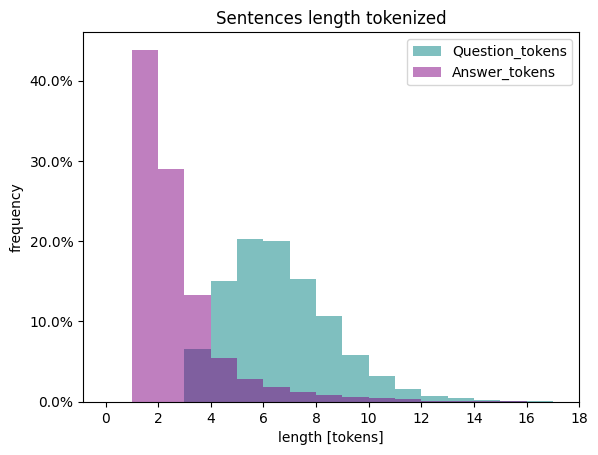

In [42]:
train_df_final_thresholds = histograms(train_df_final, cols_tokens, name = 'tokenized')

In [43]:
train_df_final.shape

(14477, 4)

In [44]:
# shortest sentences removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.16
	         median: 6.00
	         minimum: 3
	         maximum: 18)
Sentences in column Answer_tokens:
	         mean: 2.23
	         median: 2.00
	         minimum: 1
	         maximum: 17)


In [45]:
# keeping only the 95% of the data

cutoff = 95

In [46]:
# keeping only the 95% of the data

get_thresholds(train_df_final_thresholds, cutoff = cutoff)

{'Question_tokens': 10, 'Answer_tokens': 6}

In [47]:
Q_MAX, A_MAX = get_thresholds(train_df_final_thresholds, cutoff = cutoff).values()

In [48]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [49]:
# long outliers removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 5.98
	         median: 6.00
	         minimum: 3
	         maximum: 10)
Sentences in column Answer_tokens:
	         mean: 1.96
	         median: 2.00
	         minimum: 1
	         maximum: 6)


In [50]:
train_df_final.shape

(13465, 4)

# Must make pairs from the dataset with removed short and long sequences

In [51]:
train_pairs_final = get_pairs_from_df(train_df_final, cols_tokens)

In [52]:
test_pairs_final = get_pairs_from_df(test_df_final, cols_tokens)

In [53]:
len(train_pairs_final), len(test_pairs_final)

(13465, 2114)

# building the model

In [56]:
from modules.models import Seq2Seq

In [55]:
def to_tensor(vocab, tokens, seq_len, device):
    '''Converts a tokenized sentence into a tensor of indices of a given length.
    If too short, it uses padding at the beginning of the sentence as suggested by the mentor.'''
    
    tokens = [t for t in tokens if t in vocab.word2count.keys()]
    
    padded = [vocab.word2index['PAD']] * (seq_len-len(tokens)) + [vocab.word2index['SOS']] + [vocab.word2index[t] for t in tokens] + [vocab.word2index['EOS']]

    #print(len(padded))
    
    tensor = torch.Tensor(padded).long().to(device).view(-1,1)
    
    #print(tensor.shape)
    
    return tensor

In [60]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    
    # We initialize the Encoder object with appropriate layers

    def __init__(self, input_size, hidden_size, embedding_size):
        
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.embedding_size = embedding_size

        #self.hidden = torch.zeros(1, 1, hidden_size)

        self.embedding = nn.Embedding(self.input_size, self.embedding_size).to(device)
        
        # The LSTM is our last cell because it produces the hidden state        
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, 1).to(device)
    
    def forward(self, x, hidden, cell_state):
        x = self.embedding(x)
        
        x = x.view(1, 1, -1)
        
        #x = x.view(x.shape[0], 1, -1)
        
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        return x, hidden, cell_state

class Decoder(nn.Module):

    # The Decoder is initialized in the same manner.

    def __init__(self, hidden_size, output_size, embedding_size):

        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding_size = embedding_size

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size)
        
        # The LSTM produces an output by passing the hidden state to the   Linear layer
    
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim= 1)     

    def forward(self, x, hidden, cell_state):
        
        x = self.embedding(x)
        x = x.view(1, 1, -1)
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        x = self.softmax(self.fc(x[0]))
        return x, hidden, cell_state

    
    

class Seq2Seq(nn.Module):

    #def __init__(self, encoder: Encoder, decoder: Decoder, device: torch.device):
    def __init__(self, input_size, hidden_size, embedding_size, output_size, device):    
        super(Seq2Seq, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        
        self.encoder = Encoder(self.input_size, self.hidden_size, self.embedding_size).to(device)
        self.decoder = Decoder(self.hidden_size, self.output_size, self.embedding_size).to(device)
        #self.device = device
        
    def forward(self, src_batch: torch.LongTensor, trg_batch: torch.LongTensor, src_len, trg_len, teacher_forcing_ratio: float = 0.5):
        
        max_len, batch_size = trg_batch.shape
                
        trg_vocab_size = self.decoder.output_size
        
        # tensor to store decoder's output
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(device) #.to(self.device) 

         # initialize hidden and cell state
        encoder_hidden = torch.zeros([1, 1, self.hidden_size]).to(device) 
        cell_state = torch.zeros([1, 1, self.hidden_size]).to(device)

        for i in range(src_len):
        
            # last hidden & cell state of the encoder is used as the decoder's initial hidden state
            _, hidden, cell = self.encoder(src_batch[i], encoder_hidden, cell_state)
        
        
        
        trg = trg_batch[0]
        
        for i in range(trg_len):
            prediction, hidden, cell = self.decoder(trg, hidden, cell)
            outputs[i] = prediction
            
            if random.random() < teacher_forcing_ratio:
                trg = trg_batch[i]
            else:
                trg = prediction.argmax(1)
                
        return outputs

In [61]:
hidden_size = 256

In [62]:
embedding_dim = 256

In [64]:
seq2seq = Seq2Seq(input_size=Q_vocab.n_words, hidden_size=hidden_size, embedding_size=embedding_dim, output_size=A_vocab.n_words, device=device)

In [65]:
seq2seq = seq2seq.to(device)

In [66]:
from torch import optim
import torch.nn as nn

In [67]:
learning_rate = 0.001
num_epochs = 5

In [68]:
optimizer = optim.SGD(seq2seq.parameters(), lr=learning_rate)
criterion = nn.NLLLoss(ignore_index=0).to(device) # 0 is padding

In [71]:
def train(model, pairs, optimizer, criterion, device):
    model.train()  # Set the model to training mode
    
    total_loss = 0

    count = 0
    
    for pair in pairs:
        
        src = pair.question
        tgt = pair.answer
        
        src_tensor = to_tensor(vocab=Q_vocab, tokens=src, seq_len=Q_MAX, device=device)#.to(device) #.unsqueeze(0)
        tgt_tensor = to_tensor(vocab=A_vocab, tokens=tgt, seq_len=A_MAX, device=device)#.to(device) #.unsqueeze(0)

        # print(src_tensor.shape, tgt_tensor.shape)
        
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        output = model(src_tensor, tgt_tensor, src_len=src_tensor.size(0), trg_len=tgt_tensor.size(0), teacher_forcing_ratio=1)

        # Compute the loss
        loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
        count += 1 
    
        if count % 100 == 0:
            print(f'Loss {total_loss/count}')
    
    return total_loss / len(pairs)

test after each epoch

use minibatches (e.g. 16)

either count pairs and only update loss/optimizer after n pairs
 or
use bucket iterator

https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb

https://github.com/yunjey/seq2seq-dataloader/blob/master/data_loader.py

learning rate

In [72]:
for epoch in range(num_epochs):
    train_loss = train(seq2seq, train_pairs_final, optimizer, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

Loss 7.203090801239013
Loss 6.943091149330139
Loss 6.769580410321553
Loss 6.718248398303985
Loss 6.613827770233154
Loss 6.569031422138214
Loss 6.50876715864454
Loss 6.454655666351318
Loss 6.415002989768982
Loss 6.339275882720948
Loss 6.262043362097307
Loss 6.178652839064598
Loss 6.143029320240021
Loss 6.100663472584316
Loss 6.0254803296724955
Loss 5.969105757325888
Loss 5.926152554399827
Loss 5.874285455147425
Loss 5.840606117750469
Loss 5.796812346577644
Loss 5.765627592858814
Loss 5.72754963929003
Loss 5.6907799887657164
Loss 5.661697512567043
Loss 5.633557128715515
Loss 5.607118760072268
Loss 5.594328987863329
Loss 5.569085063678878
Loss 5.547084771189196
Loss 5.533639315923055
Loss 5.513751115260586
Loss 5.489338161796331
Loss 5.476822957775809
Loss 5.455531465025509
Loss 5.43871051134382
Loss 5.427478431132105
Loss 5.4153141976047205
Loss 5.401198417136544
Loss 5.393487818302252
Loss 5.380656868994236
Loss 5.371372203245396
Loss 5.361291206280391
Loss 5.347977968482084
Loss 5.3369

it can also be caused if you have a mismatch between the dimension of your input tensor and the dimensions of your nn.Linear module. (ex. x.shape = (a, b) and nn.Linear(c, c, bias=False) with c not matching)